In [47]:
import numpy as np
from serial import Serial

import spectrum_painting_plotting as sp_plot
from save_iq_data_for_arduino import save_iq_data


In [48]:
lite_model_file = "output/spectrum-painting-model-filters-8-no-quant.tflite"

! xxd -n "output_spectrum_painting_model_tflite" -i $lite_model_file  | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

iq_file = "data/numpy/SNR30_BW.npy"
windows = 256
window_length = 256
arduino_iq_file = "../arduino/spectrum_painting/data.h"

iq_data = np.load(iq_file)
save_iq_data(iq_data, windows, window_length, arduino_iq_file)

! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem21301

Library Arduino_TensorFlowLite has been declared precompiled:
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4/fpv4-sp-d16-softfp" not found
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4" not found
Sketch uses 527248 bytes (53%) of program storage space. Maximum is 983040 bytes.
Global variables use 181152 bytes (69%) of dynamic memory, leaving 80992 bytes for local variables. Maximum is 262144 bytes.

Used library           Version     Path
Arduino_TensorFlowLite 2.4.0-ALPHA /Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite
Wire                               /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0/libraries/Wire

Used platform Version Path
arduino:mbed  3.3.0   /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0
Device       : nRF52840-QIAA
Version      : Arduino Bootloader (SAM-BA extended) 2.0 [Arduino:IKXYZ]
Address  

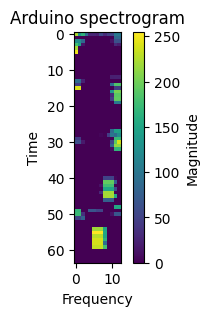

Downsample duration = 76 ms
Augment duration = 21 ms
Paint duration = 0 ms
Digitize duration = 1 ms
Inference duration = 364 ms
Total duration = 462 ms
Predicted label = ZB





In [49]:
serial = Serial(port="/dev/cu.usbmodem21301", baudrate=115200, timeout=1000)

output_rows = 64
classes = ["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"]

arduino_spectrogram = []
for _ in range(output_rows):
    real_line = serial.readline().decode('utf-8').strip()
    magnitudes = list(map(float, real_line.split(',')))

    arduino_spectrogram.append(magnitudes)

downsample_duration = int(serial.readline().strip())
augment_duration = int(serial.readline().strip())
paint_duration = int(serial.readline().strip())
digitize_duration = int(serial.readline().strip())
inference_duration = int(serial.readline().strip())
total_duration = int(serial.readline().strip())
predicted_label = int(serial.readline().strip())

sp_plot.plot_spectrogram(np.asarray(arduino_spectrogram), "Arduino spectrogram")

print(f"Downsample duration = {downsample_duration} ms")
print(f"Augment duration = {augment_duration} ms")
print(f"Paint duration = {paint_duration} ms")
print(f"Digitize duration = {digitize_duration} ms")
print(f"Inference duration = {inference_duration} ms")
print(f"Total duration = {total_duration} ms")
print(f"Predicted label = {classes[predicted_label]}")
print("\n\n")

serial.close()